# Загрузка данных

Задача: спрогнозировать тональность отзыва по его тексту (1 - позитивная, 0 - негативная)

In [27]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.base import TransformerMixin
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time

%matplotlib inline
sns.set_style('whitegrid')
sns.set_palette('Set2')

In [2]:
train = pd.read_csv('data/products_sentiment_train.tsv', names=['text', 'label'], header=0, sep='\t')
train.head()

,text,label
0,i downloaded a trial version of computer assoc...,1
1,the wrt54g plus the hga7t is a perfect solutio...,1
2,i dont especially like how music files are uns...,0
3,i was using the cheapie pail ... and it worked...,1
4,"you can manage your profile , change the contr...",1


In [3]:
train.shape

(1999, 2)

In [4]:
test = pd.read_csv('data/products_sentiment_test.tsv', header=0, sep='\t').drop('Id', axis=1)
test.head()

,text
0,"so , why the small digital elph , rather than ..."
1,3/4 way through the first disk we played on it...
2,better for the zen micro is outlook compatibil...
3,6 . play gameboy color games on it with goboy .
4,"likewise , i 've heard norton 2004 professiona..."


In [5]:
test.shape

(500, 1)

# Описательный анализ данных

In [6]:
train.describe()

,label
count,1999.000000
mean,0.636818
std,0.481037
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


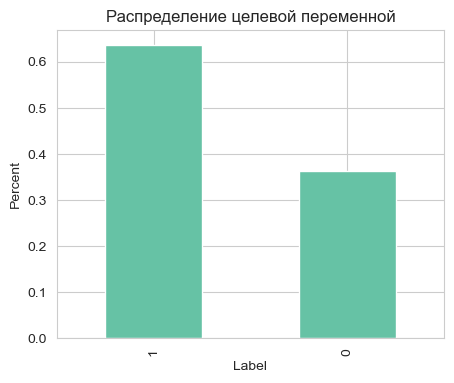

In [12]:
fig = plt.figure(figsize=(5, 4))
train['label'].value_counts(normalize=True).plot(kind='bar')
plt.title("Распределение целевой переменной")
plt.xlabel("Label")
plt.ylabel("Percent")
plt.show()

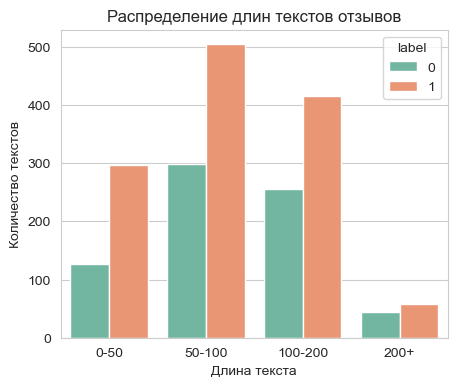

In [13]:
df = train.copy()
df['length'] = pd.cut(train['text'].apply(lambda x: len(x)), bins=[0, 50, 100, 200, float('inf')], 
       labels=['0-50', '50-100', '100-200', '200+'])

fig = plt.figure(figsize=(5, 4))
sns.countplot(x='length', hue='label', data=df)
plt.title("Распределение длин текстов отзывов")
plt.xlabel("Длина текста")
plt.ylabel("Количество текстов")
plt.show()

# Моделирование

Так как целевая переменная не сбалансирована, добавим 500 негативных отзывов в обучающую выборку

In [16]:
train = shuffle(train.append(train.iloc[list(train[train['label'] == 0].index[:500])]), random_state=10)

In [17]:
train['label'].value_counts()

1    1273
0    1226
Name: label, dtype: int64

In [18]:
X = train['text'].values
y = train['label'].values

In [19]:
X_test = test['text'].values

In [22]:
stop_words =  stopwords.words('english')

In [23]:
params_grid_vectorizer = {
    'vectorizer__max_df' : [0.85, 0.9, 0.95, 1.0],
    'vectorizer__min_df' : [1, 10, 20], 
    'vectorizer__ngram_range' : [(1, 1), (1, 2), (1, 3)],
    'vectorizer__stop_words' : [stop_words, None, 'english']
}

## Вспомогательные функции

In [24]:
def make_pipeline(vectorizer, transformer, classifier):
    return Pipeline([
            ('vectorizer', vectorizer),
            ('transformer', transformer),
            ('classifier', classifier)
        ])

In [25]:
def make_estimator(classifier, params_grid, scorer, data, labels):
    pipeline = make_pipeline(CountVectorizer(), TfidfTransformer(), classifier)
    grid_cv = RandomizedSearchCV(pipeline, params_grid, scoring=scorer, cv=5, random_state=777, n_iter=100)
    grid_cv.fit(data, labels)
    return grid_cv

In [28]:
class DenseTransformer(TransformerMixin):
    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

## Линейные классификаторы

In [191]:
for name, clf in {'LogisticRegression': LogisticRegression, 'LinearSVC': LinearSVC, 
               'SGDClassifier': SGDClassifier, 'RidgeClassifier': RidgeClassifier}.items():
    score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), clf(random_state=777)), X, y, cv=5).mean()
    print(f"{name} - {score:.3}")

LogisticRegression - 0.818
LinearSVC - 0.841
SGDClassifier - 0.834
RidgeClassifier - 0.833


### Настройка параметров

In [213]:
results = pd.DataFrame(columns=['clf', 'score', 'time', 'params'])
for name, clf, params_grid in [('LogisticRegression', LogisticRegression,
                {'classifier__C': np.arange(0.1, 2, 0.1),
                'classifier__max_iter': np.arange(50, 500, 50),
                'classifier__solver': ['lbfgs', 'liblinear', 'sag']}), 
                               
                    ('LinearSVC', LinearSVC,
                {'classifier__loss': ['hinge', 'squared_hinge'], 
                'classifier__max_iter': np.arange(100, 1000, 50),
                'classifier__tol': [1e-5, 1e-4, 1e-3],
                'classifier__C': np.arange(0.1, 2, 0.1)}), 
                               
                    ('SGDClassifier', SGDClassifier,
                {'classifier__loss': ['log', 'hinge', 'modified_huber'], 
                'classifier__penalty':  ['l1', 'l2', 'elasticnet'], 
                'classifier__max_iter': np.arange(100, 1000, 50),
                'classifier__tol': np.arange(1e-5, 1e-3, 1e-5)}), 
                               
                    ('RidgeClassifier', RidgeClassifier,
                {'classifier__alpha': np.arange(0.1, 5, 0.1),
                'classifier__normalize': [True, False], 
                'classifier__tol': np.arange(1e-4, 1e-2, 1e-4),
                'classifier__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']})]:
    
    
    

    start_time = time.time()
    
    grid_search = make_estimator(clf(random_state=777), 
                                    {**params_grid_vectorizer, **params_grid}, 'accuracy', X, y)
    
    elapsed_time = time.time() - start_time

    results.loc[len(results)] = [name, 
                                 grid_search.best_score_, 
                                 time.strftime("%H:%M:%S", time.gmtime(elapsed_time)), 
                                 grid_search.best_params_]
    
results['score'] = results['score'].map('{:,.3f}'.format)
results_linear = copy.deepcopy(results)
results_linear.sort_values(by='score', ascending=False)

,clf,score,time,params
1,LinearSVC,0.863,00:01:42,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 3), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.9, 'classifier__tol': 0.0001, 'classifier__max_iter': 700, 'classifier__loss': ..."
2,SGDClassifier,0.860,00:02:03,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.95, 'classifier__tol': 0.0004000000000000001, 'classifier__penalty': 'l2', 'cla..."
3,RidgeClassifier,0.859,00:01:32,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.9, 'classifier__tol': 0.0047, 'classifier__solver': 'auto', 'classifier__normal..."
0,LogisticRegression,0.852,00:02:04,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 3), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.95, 'classifier__solver': 'lbfgs', 'classifier__max_iter': 250, 'classifier__C'..."


In [202]:
pd.set_option('max_colwidth', 200)

## Байесовские классификаторы

In [206]:
for name, clf in {'MultinomialNB': MultinomialNB, 'BernoulliNB': BernoulliNB, 
               'GaussianNB': GaussianNB}.items():
    if name == 'GaussianNB':
        score = cross_val_score(Pipeline([('vectorizer', CountVectorizer()), ('transformer', TfidfTransformer()),
                                  ('dense', DenseTransformer()), ('classifier', GaussianNB())]), X, y, cv=5).mean()
    else:
        score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), clf()), X, y, cv=5).mean()
    print(f"{name} - {score:.3}")

MultinomialNB - 0.818
BernoulliNB - 0.821
GaussianNB - 0.705


### Настройка параметров

In [214]:
results = pd.DataFrame(columns=['clf', 'score', 'time', 'params'])
for name, clf, params_grid in [('MultinomialNB', MultinomialNB,
                {'classifier__alpha': np.logspace(0, 5, 100), 
                'classifier__fit_prior': [True, False]}), 
                               
                    ('BernoulliNB', BernoulliNB,
                {'classifier__alpha': np.logspace(0, 5, 100),
                'classifier__fit_prior': [True, False]})]:

    start_time = time.time()
    
    grid_search = make_estimator(clf(), 
                                    {**params_grid_vectorizer, **params_grid}, 'accuracy', X, y)
    
    elapsed_time = time.time() - start_time

    results.loc[len(results)] = [name, 
                                 grid_search.best_score_, 
                                 time.strftime("%H:%M:%S", time.gmtime(elapsed_time)), 
                                 grid_search.best_params_]
    
results['score'] = results['score'].map('{:,.3f}'.format)
results_bayes = copy.deepcopy(results)
results_bayes.sort_values(by='score', ascending=False)

,clf,score,time,params
1,BernoulliNB,0.858,00:01:41,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 1, 'vectorizer__max_df': 1.0, 'classifier__fit_prior': True, 'classifier__alpha': 1.0}"
0,MultinomialNB,0.856,00:01:44,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 1, 'vectorizer__max_df': 1.0, 'classifier__fit_prior': True, 'classifier__alpha': 1.0}"


## Решающие деревья

In [210]:
for name, clf in {'DecisionTreeClassifier': DecisionTreeClassifier, 'RandomForestClassifier': RandomForestClassifier, 
               'BaggingClassifier': BaggingClassifier, 'GradientBoostingClassifier': GradientBoostingClassifier}.items():
    score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), clf(random_state=777)), X, y, cv=5).mean()
    print(f"{name} - {score:.2}")

DecisionTreeClassifier - 0.77
RandomForestClassifier - 0.84
BaggingClassifier - 0.78
GradientBoostingClassifier - 0.76


### Настройка параметров

In [223]:
results = pd.DataFrame(columns=['clf', 'score', 'time', 'params'])
for name, clf, params_grid in [('DecisionTreeClassifier', DecisionTreeClassifier,
                {'classifier__max_depth': np.arange(1, 30, 1).tolist()+[None],
                'classifier__min_samples_split': np.arange(2, 6, 1),
                'classifier__min_samples_leaf': [1, 2, 3],
                'classifier__min_impurity_decrease': np.logspace(-10, -6, 5).tolist()+[0]}), 
                               
                    ('RandomForestClassifier', RandomForestClassifier,
                {'classifier__n_estimators': np.arange(1, 30, 1),
                'classifier__max_depth': np.arange(1, 30, 1).tolist()+[None],
                'classifier__min_samples_split': np.arange(2, 6, 1),
                'classifier__min_samples_leaf': [1, 2, 3],
                'classifier__max_features': ['auto', 'sqrt', 'log2'],
                'classifier__min_impurity_decrease': np.logspace(-10, -6, 5).tolist()+[0]}),
                              
                    ('BaggingClassifier', BaggingClassifier,
                {'classifier__n_estimators': np.arange(50, 300, 100),
                'classifier__warm_start': [False, True], 
                'classifier__bootstrap_features': [False, True]}),
                              
                    ('GradientBoostingClassifier', GradientBoostingClassifier,
                {'classifier__n_estimators': np.arange(50, 300, 100),
                'classifier__max_depth': np.arange(1, 30, 1).tolist()+[None],
                'classifier__min_samples_split': np.arange(2, 6, 1),
                'classifier__max_features': ['auto', 'sqrt', 'log2'],
                'classifier__subsample': np.arange(0.6, 1, 0.1)})]:
    
    
    
    start_time = time.time()
    
    grid_search = make_estimator(clf(random_state=777), 
                                    {**params_grid_vectorizer, **params_grid}, 'accuracy', X, y)
    
    elapsed_time = time.time() - start_time

    results.loc[len(results)] = [name, 
                                 grid_search.best_score_, 
                                 time.strftime("%H:%M:%S", time.gmtime(elapsed_time)), 
                                 grid_search.best_params_]
    
results['score'] = results['score'].map('{:,.3f}'.format)
results_trees = copy.deepcopy(results)
results_trees.sort_values(by='score', ascending=False)

,clf,score,time,params
3,GradientBoostingClassifier,0.860,00:29:29,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 1), 'vectorizer__min_df': 1, 'vectorizer__max_df': 1.0, 'classifier__subsample': 0.7, 'classifier__n_estimators': 150, 'classifier__..."
2,BaggingClassifier,0.848,03:16:37,"{'vectorizer__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'you're', 'you've', 'you'll', 'you'd', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his'..."
1,RandomForestClassifier,0.826,00:02:00,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 10, 'vectorizer__max_df': 0.95, 'classifier__n_estimators': 21, 'classifier__min_samples_split': 3, 'class..."
0,DecisionTreeClassifier,0.780,00:02:02,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 10, 'vectorizer__max_df': 0.9, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'cla..."


## LightGBM, XGBoost

In [225]:
for name, clf in {'LightGBM': lgb.LGBMClassifier, 'XGBoost': xgb.XGBClassifier}.items():
    score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), clf(random_state=777)), X, y, cv=5).mean()
    print(f"{name} - {score:.2}")

LightGBM - 0.81
XGBoost - 0.81


### Настройка параметров

In [288]:
results = pd.DataFrame(columns=['clf', 'score', 'time', 'params'])
for name, clf, params_grid in [
                    ('XGBoost', xgb.XGBClassifier,
                {'classifier__learning_rate':np.arange(0.1,0.5,0.1), 
                 'classifier__max_depth':range(1,10), 
                 'classifier__n_estimators':range(1, 100, 10), 
                 'classifier__min_child_weight':range(1,5)}),
    
                    ('LightGBM', lgb.LGBMClassifier,
                {'classifier__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5],
                 'classifier__boosting_type': ['gbdt', 'dart'],
                 'classifier__max_depth': range(0,15,5)})]:
    
    
    
    start_time = time.time()
    
    grid_search = make_estimator(clf(random_state=777), 
                                    {**params_grid_vectorizer, **params_grid}, 'accuracy', X, y)
    
    elapsed_time = time.time() - start_time

    results.loc[len(results)] = [name, 
                                 grid_search.best_score_, 
                                 time.strftime("%H:%M:%S", time.gmtime(elapsed_time)), 
                                 grid_search.best_params_]
    
results['score'] = results['score'].map('{:,.3f}'.format)
results_gb = copy.deepcopy(results)
results_gb.sort_values(by='score', ascending=False)

,clf,score,time,params
1,LightGBM,0.815,00:05:55,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 10, 'vectorizer__max_df': 0.85, 'classifier__max_depth': 0, 'classifier__learning_rate': 0.3, 'classifier_..."
0,XGBoost,0.800,00:06:51,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 3), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.85, 'classifier__n_estimators': 81, 'classifier__min_child_weight': 2, 'classif..."


# Выбор модели

In [289]:
results = pd.concat([results_linear, results_bayes, results_trees, results_gb], ignore_index=True)
results.sort_values(by='score', ascending=False)

,clf,score,time,params
1,LinearSVC,0.863,00:01:42,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 3), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.9, 'classifier__tol': 0.0001, 'classifier__max_iter': 700, 'classifier__loss': ..."
2,SGDClassifier,0.860,00:02:03,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.95, 'classifier__tol': 0.0004000000000000001, 'classifier__penalty': 'l2', 'cla..."
9,GradientBoostingClassifier,0.860,00:29:29,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 1), 'vectorizer__min_df': 1, 'vectorizer__max_df': 1.0, 'classifier__subsample': 0.7, 'classifier__n_estimators': 150, 'classifier__..."
3,RidgeClassifier,0.859,00:01:32,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.9, 'classifier__tol': 0.0047, 'classifier__solver': 'auto', 'classifier__normal..."
5,BernoulliNB,0.858,00:01:41,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 1, 'vectorizer__max_df': 1.0, 'classifier__fit_prior': True, 'classifier__alpha': 1.0}"
4,MultinomialNB,0.856,00:01:44,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 1, 'vectorizer__max_df': 1.0, 'classifier__fit_prior': True, 'classifier__alpha': 1.0}"
0,LogisticRegression,0.852,00:02:04,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 3), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.95, 'classifier__solver': 'lbfgs', 'classifier__max_iter': 250, 'classifier__C'..."
8,BaggingClassifier,0.848,03:16:37,"{'vectorizer__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'you're', 'you've', 'you'll', 'you'd', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his'..."
7,RandomForestClassifier,0.826,00:02:00,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 10, 'vectorizer__max_df': 0.95, 'classifier__n_estimators': 21, 'classifier__min_samples_split': 3, 'class..."
11,LightGBM,0.815,00:05:55,"{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 10, 'vectorizer__max_df': 0.85, 'classifier__max_depth': 0, 'classifier__learning_rate': 0.3, 'classifier_..."


In [311]:
results.sort_values(by='score', ascending=False).iloc[0]['params']

{'vectorizer__stop_words': None,
 'vectorizer__ngram_range': (1, 3),
 'vectorizer__min_df': 1,
 'vectorizer__max_df': 0.9,
 'classifier__tol': 0.0001,
 'classifier__max_iter': 700,
 'classifier__loss': 'hinge',
 'classifier__C': 1.6}

## Проверка на тестовой выборке

In [34]:
model = make_pipeline(CountVectorizer(ngram_range=(1, 3), min_df=1, max_df=0.9),
                    TfidfTransformer(),
                    LinearSVC(max_iter=700, loss='hinge', C=1.6, tol=0.0001, random_state=777))
model.fit(X, y)
predictions = model.predict(X_test)

In [39]:
predictions[-5:]

array([0, 1, 0, 0, 1], dtype=int64)

In [38]:
X_test[-5:]

array(['i took perfect care of this player and still it died in the week after the lousy 90 day warranty ended . ',
       "it 's a very intuitive program . ",
       'the only drawback is the viewfinder is slightly blocked by the lens . ',
       'it films 10 second video , for crying out loud .',
       'everything shines of quality .'], dtype=object)